<a href="https://colab.research.google.com/github/paulsubarna/DGM_tutorials-/blob/main/gans_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tutorial 5: Generative Adversarial Networks (GANs)
In this tutorial, we introduce implicit generative models, with a particular focus on Generative Adversarial Networks (GANs). Up to this point, you have learned about how VAEs approach generative modelling and the difficulties associated with their training objective in particular. For additional info on this, please refer to the lecture material.

GANs offer an alternative generative modeling framework. They consist of a generator–discriminator architecture, where the generator maps noise vectors to synthetic samples, and the discriminator evaluates whether a given sample is real or generated. Through an adversarial loss, both models are jointly optimized: the generator aims to produce samples that the discriminator cannot reliably distinguish from real data, while the discriminator learns to improve its classification performance.

The structure of this notebook follows the standard workflow used in previous modules:
data loading, generator design, discriminator design, and training and evaluation.


**Setup and Imports**

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

**DISCLAIMER**

The presented code is not optimized, it serves an educational purpose. It is written for CPU, it uses only fully-connected networks and an extremely simplistic dataset. However, it contains all components that can help to understand how Generative Adversarial Networks (GANs) work, and it should be rather easy to extend it to more sophisticated models. This code could be run almost on any laptop/PC, and it takes a couple of minutes top to get the result.

## Dataset: Digits

In this example, we go wild and use a dataset that is simpler than MNIST! We use a scipy dataset called Digits. It consists of ~1500 images of size 8x8, and each pixel can take values in $\{0, 1, \ldots, 16\}$.

The goal of using this dataset is that everyone can run it on a laptop, without any gpu etc.

In [ ]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

## GANs: Generator Module

### TO_DO

1. Model your Generator class
2. It should have three main methods: Generate, Sample, and Forward

In [ ]:
class Generator(nn.Module):
    def __init__(self, generator_net, z_size):
        super(Generator, self).__init__()

        # We need to init the generator neural net.
        self.generator_net = generator_net
        # We also need to know the size of the latents.
        self.z_size = z_size

    def generate(self, z):
        # Generating for given z is equivalent to applying the neural net.
        return self.generator_net(z)

    def sample(self, batch_size=16):
        # For sampling, we need to sample first latents.
        z = torch.randn(batch_size, self.z_size)
        return self.generate(z)

    def forward(self, z=None):
        if z is None:
            return self.sample()
        else:
            return self.generate(z)


### Discriminator

## TO_DO

In a similar way, design your Discriminator class
1. This module only host a forward method used to distinguish between real sample and a generated one

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_net):
        super(Discriminator, self).__init__()
        # We need to init the discriminator neural net.
        self.discriminator_net = discriminator_net

    def forward(self, x):
        # The forward pass is just about applying the neural net.
        return self.discriminator_net(x)

### Generatove Adversial Network

## TO_DO

1. Now combine your generator and discriminator class to design your first GAN model.

In [ ]:
class GAN(nn.Module):
    def __init__(self, generator, discriminator, EPS=1.e-5):
        super(GAN, self).__init__()

        # To put everything together, we need the generator and
        # the discriminator. NOTE: Both are intanced of classes!
        self.generator = generator
        self.discriminator = discriminator

        # For numerical issue, we introduce a small epsilon.
        self.EPS = EPS

    def forward(self, x_real, reduction='avg', mode='discriminator'):
        # The forward pass calculates the adversarial loss.
        # More specifically, either its part for the generator or
        #  the part for the discriminator.
        if mode == 'generator':
            # For the generator, we first sample FAKE data.
            x_fake_gen = self.generator.sample(x_real.shape[0])

            # Then, we calculate outputs of the discriminator for the FAKE data.
            # NOTE: We clamp here for the numerical stability later on.
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.EPS, 1. - self.EPS)

            # The loss for the generator is log(1 - D(G(z))).
            loss = torch.log(1. - d_fake)

        elif mode == 'discriminator':
            # For the discriminator, we first sample FAKE data.
            x_fake_gen = self.generator.sample(x_real.shape[0])

            # Then, we calculate outputs of the discriminator for the FAKE data.
            # NOTE: We clamp for the numerical stability later on.
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.EPS, 1. - self.EPS)

            # Moreover, we calculate outputs of the discriminator for the REAL data.
            # NOTE: We clamp for... the numerical stability (again).
            d_real = torch.clamp(self.discriminator(x_real), self.EPS, 1. - self.EPS)

            # The final loss for the discriminator is log(1 - D(G(z))) + log D(x).
            # NOTE: We take the minus sign because we MAXIMIZE the adversarial loss wrt
            # discriminator, so we MINIMIZE the negative adversarial loss wrt discriminator.
            loss = -(torch.log(d_real) + torch.log(1. - d_fake))

        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

    def sample(self, batch_size=64):
        return self.generator.sample(batch_size=batch_size)

## Evaluation and Training functions

There is not much to discuss here. We will follow the same training and evaluation script as the previous tutorials

However, it is worth noting that unlike VAEs, for GANs we will use two **optimizers**, one for Generator module and one for Discriminator class.

In [ ]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model', weights_only=False)

    model_best.eval()
    loss_gen = 0.
    loss_dis = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t_gen = model_best.forward(test_batch, reduction='sum', mode='generator')
        loss_t_dis = model_best.forward(test_batch, reduction='sum', mode='discriminator')

        loss_gen = loss_gen + loss_t_gen.item()
        loss_dis = loss_dis + loss_t_dis.item()

        N = N + test_batch.shape[0]

    loss_gen = loss_gen / N
    loss_dis = loss_dis / N

    if epoch is None:
        print(f'FINAL LOSS: gen={loss_gen}, dis={loss_dis}')
    else:
        print(f'Epoch: {epoch}, val gen={loss_gen}, val dis={loss_dis}')

    return loss_gen, loss_dis


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model', weights_only=False)
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.show()
    #plt.close()


def plot_curve(name, nll_val, xaxis='epochs', yaxis='nll'):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

## Training step




In [ ]:
def training(name, num_epochs, model, optimizer_gen, optimizer_dis, training_loader, val_loader):
    gen_val = []
    dis_val = []
    best_loss = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):

            # -Discriminator
            loss_dis = model.forward(batch, mode='discriminator')

            optimizer_dis.zero_grad()
            optimizer_gen.zero_grad()
            loss_dis.backward(retain_graph=True)
            optimizer_dis.step()

            # -Generator
            loss_gen = model.forward(batch, mode='generator')

            optimizer_dis.zero_grad()
            optimizer_gen.zero_grad()
            loss_gen.backward(retain_graph=True)
            optimizer_gen.step()

        # Validation
        loss_val_gen, loss_val_dis = evaluation(val_loader, model_best=model, epoch=e)
        gen_val.append(loss_val_gen)  # save for plotting
        dis_val.append(loss_val_dis)  # save for plotting

        torch.save(model, name + '.model')
        samples_generated(name, val_loader, extra_name="_epoch_" + str(e))

    gen_val = np.asarray(gen_val)
    dis_val = np.asarray(dis_val)

    return gen_val, dis_val


## Experiments

1. Define your training functions.
2. Try exploring different choices from torch.Transform and evaluate how it affects your training and test performances!!

In [ ]:
transforms_train = tt.Compose( [tt.Lambda(lambda x: 2*(x / 17.)-1.),
                              tt.Lambda(lambda x: torch.from_numpy(x)),
                              tt.Lambda(lambda x: x + 0.03 * torch.randn_like(x))
                              ])

transforms_val  = tt.Compose( [tt.Lambda(lambda x: 2*(x / 17.)-1.),
                               tt.Lambda(lambda x: torch.from_numpy(x)),
                               ])

In [ ]:
train_data = Digits(mode='train', transforms=transforms_train)
val_data = Digits(mode='val', transforms=transforms_val)
test_data = Digits(mode='test', transforms=transforms_val)

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Hyperparameters

1. Set your hyperparameters and play around with the learning rates of the generator and discriminator.



In [ ]:
D = 64   # input dimension
L = 16 # number of latents
M = 128  # the number of neurons in scale (s) and translation (t) nets

lr_gen = 3e-4# learning rate
lr_dis =  3e-4# learning rate
num_epochs = 100 # max. number of epochs

**Creating a folder for results**

In [ ]:
if not(os.path.exists('results')):
    os.mkdir('results')
name = 'gan_' + str(L)
result_dir ='results/' + name + '/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

## Initializing Generator and Discriminator model
- You are free to choose any model type between a normal MLP and conv layers !!


In [ ]:
# First, we initialize the generator and the discriminator
# -generator
generator_net = nn.Sequential(nn.Linear(L, M), nn.ReLU(),
                              nn.Linear(M, D), nn.Tanh())

generator = Generator(generator_net, z_size=L)

# -discriminator
discriminator_net = nn.Sequential(nn.Linear(D, M), nn.ReLU(),
                                  nn.Linear(M, 1), nn.Sigmoid())

discriminator = Discriminator(discriminator_net)

# Eventually, we initialize the full model
model = GAN(generator=generator, discriminator=discriminator)

**Optimizer - here we use Adam**

In [ ]:
# OPTIMIZER
optimizer_gen = torch.optim.Adam(model.generator.parameters(), lr=lr_gen)
optimizer_dis = torch.optim.Adam(model.discriminator.parameters(), lr=lr_dis)

**Training loop**

In [ ]:
# Training procedure
gen_val, dis_val = training(name=result_dir + name,
                            num_epochs=num_epochs,
                            model=model,
                            optimizer_gen=optimizer_gen,
                            optimizer_dis=optimizer_dis,
                            training_loader=training_loader,
                            val_loader=val_loader)

Epoch: 0, val gen=-0.7472136906215123, val dis=1.166059308733259
Epoch: 1, val gen=-0.8500314331054688, val dis=1.135064185006278
Epoch: 2, val gen=-0.9551446206229074, val dis=1.1879321725027903
Epoch: 3, val gen=-1.00646728515625, val dis=1.2327047402518136
Epoch: 4, val gen=-0.9025940377371652, val dis=1.223999797276088
Epoch: 5, val gen=-0.7999799074445452, val dis=1.2215580095563616
Epoch: 6, val gen=-0.7705831037248884, val dis=1.288671133858817
Epoch: 7, val gen=-0.8113602556501116, val dis=1.360650634765625
Epoch: 8, val gen=-0.8278268105643136, val dis=1.3717750767299106
Epoch: 9, val gen=-0.8233986772809709, val dis=1.3484803336007254
Epoch: 10, val gen=-0.7842698560442243, val dis=1.2809794289725167
Epoch: 11, val gen=-0.6464245550973075, val dis=1.1075491115025111
Epoch: 12, val gen=-0.5586602238246373, val dis=0.9475501033238002
Epoch: 13, val gen=-0.5557885905674526, val dis=0.9004605102539063
Epoch: 14, val gen=-0.5914652960641044, val dis=0.9521721649169922
Epoch: 15, v

## Evaluation & Visualization

FINAL LOSS: gen=-0.4667113045984733, dis=0.9452164669164875


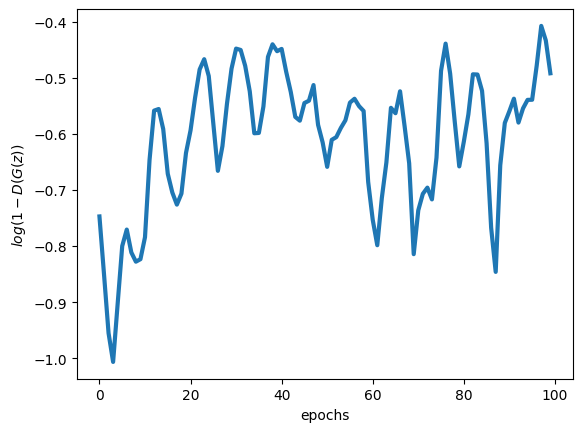

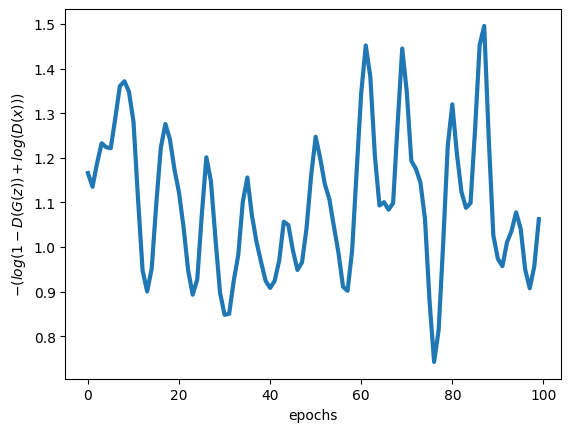

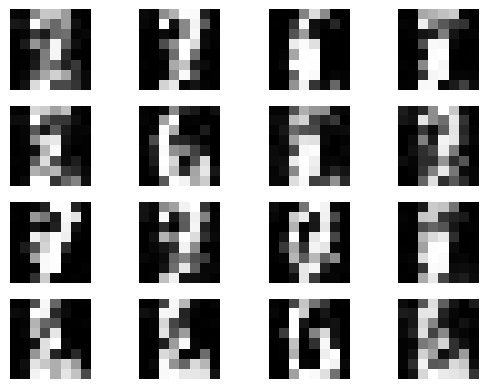

In [ ]:
test_gen_loss, test_dis_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_gen_loss))
f.write('\n')
f.write(str(test_dis_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name + '_gen', gen_val, yaxis='$log(1-D(G(z))$')
plot_curve(result_dir + name + '_dis', dis_val, yaxis='$-(log(1-D(G(z)) + log(D(x)))$')

samples_generated(result_dir + name, test_loader, extra_name='FINAL')

## Questions to evaluate

1. Perform the same training process of GANs, however this time with different noise distributions such as gaussian noise or uniform noise

In [ ]:
# You can sample random variables from uniform distributions of range (m, n) using np.random.uniform or torch.rand


m=-1
n=1
batch_size = 100
latent_variables = 16
z = np.random.uniform(-1, 1, (batch_size, latent_variables))
z = torch.rand(batch_size, latent_variables)* (n-m) + m

# Simple pass this generator.sample and train yours GANs again